# MLP model approach

In [204]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
#import random
import matplotlib.pyplot as plt
import seaborn as sns

#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


import warnings
warnings.filterwarnings('ignore')

In [2]:
# %pip install openpyxl
# %pip install tensorflow

-------------------------------

## Prepare data 

In [206]:
#  Load the climate data

file_path = "../data/Kalam_Climate_Data.xlsx"   
climate_df = pd.read_excel(file_path)

climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

# Extract date

climate_df['date'] = climate_df['Date Time'].dt.date

# Daily aggregation
daily_climate = climate_df.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

daily_climate["date"] = pd.to_datetime(daily_climate["date"])

start_df = min(daily_climate["date"])
end_df = max(daily_climate["date"])

# Filter DataFrame
extra_month_df = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]


new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}


extra_month_df.rename(columns=new_names, inplace=True)

all_data_df = pd.read_csv("../data/Data.csv")

df_dummies = all_data_df[[x for x in all_data_df.columns if x not in ('date_time', 'current', 'power_factor', 'kwh', 'consumer_device_9')]].copy()
df_dummies = df_dummies.groupby('Source').agg({'mean'})
# Flatten columns
df_dummies.columns = [''.join(col).replace('mean','') for col in df_dummies.columns.values]
df_dummies = pd.get_dummies(df_dummies, columns=['consumer_device_x'], prefix="device", dtype=float).reset_index()
# Flatten columns
df_dummies.columns = [col.replace('.0', '') for col in df_dummies.columns.values]
df_dummies["red"] = df_dummies["v_red"].notna().astype(int)
df_dummies["blue"] = df_dummies["v_blue"].notna().astype(int)
df_dummies["yellow"] = df_dummies["v_yellow"].notna().astype(int)
df_dummies.pop("v_red")
df_dummies.pop("v_blue")
df_dummies.pop("v_yellow")


all_data_df.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow",
                           "current", "power_factor"], inplace=True)
all_data_df.head()


# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])


# Extract date (drop time)
all_data_df['date'] = all_data_df['date_time'].dt.date

# Group by Source (consumer_device + data_user) and date
daily_df = all_data_df.groupby(['Source', 'date']).agg({
    'kwh': 'sum'
})

daily_df = daily_df.reset_index()

# Ensure datetime index
daily_df = daily_df.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily_df = daily_df.join(daily_climate, how="left")


merged_daily_df.reset_index(inplace=True)

merged_daily_df.to_csv("../data/second_daily_merged_hydro_climate.csv", index=False)


# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily_df.rename(columns=new_names, inplace=True)

## PK_20250909: Funktions

In [207]:
##PK_20250909: Here we can quickly look at the time series of engeneered features
def plot_tseries_2_fill(file_extension,
                        x,
                        y1=None,
                        y2=None,
                        y1_fill_lower=None,
                        y1_fill_upper=None,
                        y1_scaling=None,
                        y2_fill_lower=None,
                        y2_fill_upper=None,
                        y2_scaling=None,
                        zero_hline=False,
                        y1_unit='',
                        y2_unit='',
                        title=''
                        ):
    """Plot time series of up to two variables with fill between ranges."""
    fig, ax1 = plt.subplots(figsize=(14, 5))
    if y1_fill_lower is not None and y1_fill_upper is not None:
        ax1.fill_between(x, y1_fill_lower, y1_fill_upper, facecolors='grey', alpha=0.5, label='inner quartiles')
    if y1 is not None:
        ax1.plot(x, y1, 'k-', label='median')
    if y1_scaling is not None:
        ax1.set_yscale(y1_scaling, linthresh=0.1)
        ax1.set_ylim(0)
    ax1.set_ylabel(y1_unit)
    ax1.tick_params(rotation=30)
    if y2 is not None or (y2_fill_lower is not None and y2_fill_upper is not None):
        ax2 = ax1.twinx()
        if y2_fill_lower is not None and y2_fill_upper is not None :
            ax2.fill_between(x, y2_fill_lower, y2_fill_upper, facecolors='skyblue', alpha=0.5, label='inner quartiles')
        if y2 is not None: 
            ax2.plot(x, y2, 'b-')
        if y2_scaling is not None:
            ax2.set_yscale(y1_scaling, linthresh=0.1)
            ax2.set_ylim(0)
        if zero_hline:
            ax2.hlines(0, x[0], x[-1], 'b', linestyles=':')
        ax2.set_ylabel(y2_unit)
        ax2.spines['right'].set_color('b')
        ax2.tick_params(axis='y', colors='b')
        ax2.yaxis.label.set_color('b')
    plt.xlim(x[0], x[-1])
    plt.title(title)
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/tseries_quantiles_{title}.png')
    plt.close()


def plot_distribution(data, file_extension, second_extension, draw_5_95=False):
    """Plot distribution of a feature."""
    g = sns.pairplot(data.sample(1000), diag_kind='kde')
    if draw_5_95:
        #Loop over diagonals
        for i, col in enumerate(data.columns):
            if col == 'Date':
                continue
            ax = g.axes[-1, i-1]   # diagonal axis for feature i
            # Compute percentiles
            p5, p95 = np.percentile(data[col], [5, 95])
            # Draw lines
            ax.axvline(p5, color="red", linestyle="--")
            ax.axvline(p95, color="red", linestyle="--")
    #plt.show()
    g.save(f'../submissions/{file_extension}/pairplot{second_extension}.png')
    plt.close()


# --- Plot historical vs predictions for a few sources ---
def plot_example_sources(data, pred_unseen, pred_train, pred_test, file_extension, second_extension, selected_sources=True):

    # --- Total demand (sum of all sources) ---
    df_total = data.groupby("Date")["kwh"].sum().reset_index()
    preds_total = pred_unseen.groupby("Date")["pred_kwh"].sum().reset_index()

    fig = plt.figure(figsize=(12,5))
    plt.plot(df_total["Date"], df_total["kwh"], 'b-', label="Actual Total (history)")
    plt.plot(preds_total["Date"], preds_total["pred_kwh"], label="Predicted Total (extra month)", alpha=0.7, c='tab:orange', linestyle="--")
    plt.title("Total Electricity Demand")
    plt.xlabel("Date")
    plt.ylabel("Total kWh")
    plt.legend()
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/tseries_model_sum{second_extension}.png')
    plt.close()

    # --- Total demand (mean of all sources) ---
    df_total = data.groupby("Date")["kwh"].mean().reset_index()
    preds_total = pred_unseen.groupby("Date")["pred_kwh"].mean().reset_index()
    pred_train_total = pred_train.groupby("Date")["kwh"].mean().reset_index()
    pred_test_total = pred_test.groupby("Date")["kwh"].mean().reset_index()

    fig = plt.figure(figsize=(12,5))
    plt.plot(df_total["Date"], df_total["kwh"], 'b-', label="Actual Total (history)")
    plt.plot(preds_total["Date"], preds_total["pred_kwh"], label="Predicted Total (extra month)", alpha=0.7, c='tab:orange', linestyle="--")
    plt.plot(pred_train_total["Date"], pred_train_total["kwh"], 'ro', label="Predicted Total (train)", alpha=0.4, markersize=2)
    plt.plot(pred_test_total["Date"], pred_test_total["kwh"], 'yo', label="Predicted Total (test)", alpha=0.4, markersize=2)
    plt.title("Average Electricity Demand")
    plt.xlabel("Date")
    plt.ylabel("Total kWh")
    plt.legend()
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/tseries_model_avg{second_extension}.png')
    plt.close()
    
    # --- Demand (selected sources) ---
    if selected_sources:
        with open('../data/users_to_plot.txt', 'r') as file:
            sample_sources = []
            for ll, line in enumerate(file.readlines()):
                sample_sources.append([])
                for word in line.split(' '):
                    sample_sources[ll].append(word.rstrip('\n'))
        file.close()

        for i, srcs in enumerate(sample_sources):
            fig, ax = plt.subplots(len(srcs), 1, sharex=True, figsize=(12, len(srcs)*3))
            for ss, src in enumerate(srcs):
                ax[ss].plot(data[data.Source == src]["Date"], data[data.Source == src]["kwh"], 'b-', label="Actual (history)")
                ax[ss].plot(pred_unseen[pred_unseen.Source == src]["Date"], pred_unseen[pred_unseen.Source == src]["pred_kwh"], c='tab:orange', linestyle='--', label="Predicted (extra month)", alpha=0.7)
                ax[ss].plot(pred_train[pred_train.Source == src].index, pred_train[pred_train.Source == src]['kwh'], 'ro', label="Predicted (train)", alpha=0.4, markersize=2)
                ax[ss].plot(pred_test[pred_test.Source == src].index, pred_test[pred_test.Source == src]['kwh'], 'yo', label="Predicted (test)", alpha=0.4, markersize=2)
                ax[ss].set_ylabel("kWh")
                ax[ss].set_title(f"Source: {src}")
            plt.xlabel("Date")
            plt.tight_layout()
            plt.legend()
            #plt.show()
            fig.savefig(f'../submissions/{file_extension}/tseries_model_devices_{i}{second_extension}.png')
            plt.close()


def plot_model_validation(y_test, y_pred, file_extension, second_extension):
    # ===================================================
    # --- Residual Analysis (using train/test predictions) ---
    # Compute residuals for test set
    y_test = y_test.kwh
    y_pred = y_pred.kwh
    
    residuals = y_test - y_pred

    # Residuals distribution
    fig = plt.figure(figsize=(8,5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.title("Residual Distribution (Test Set)")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/val_model_residuals{second_extension}.png')
    plt.close()

    # Scatter plot: Predicted vs Actual
    fig = plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([0, max(y_test)], [0, max(y_test)], "r--")  # perfect line
    plt.xlabel("Actual kWh")
    plt.ylabel("Predicted kWh")
    plt.title("Predicted vs Actual (Test Set)")
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/val_pred_vs_act{second_extension}.png')
    plt.close()

    # Residuals vs Predictions (check bias)
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted kWh")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residuals vs Predicted Values (Test Set)")
    #plt.show()
    fig.savefig(f'../submissions/{file_extension}/val_pred_vs_resid{second_extension}.png')
    plt.close()


def plot_power_per_device(data, feature, file_extension):

    device_total = data.groupby(['consumer_device_x', "date"])[feature].sum().reset_index()

    for ii, i in enumerate(data.consumer_device_x.unique()):
        fig = plt.figure(figsize=(12,5))
        plt.plot(device_total[device_total.consumer_device_x == i]["date"], device_total[device_total.consumer_device_x == i][feature], 'b-', label="Actual device (history)")
        plt.title(f"Device {i} total {feature}")
        plt.xlabel("Date"); plt.ylabel(feature)
        plt.xlim(start_df, end_df)
        plt.legend()
        #plt.show()
        fig.savefig(f'../submissions/{file_extension}/tseries_{feature}_power_device_{ii}.png')
    plt.close()


def prepare_submission(pred, file_extension, add_to_csv=False):
    if not add_to_csv:
        sub = pd.read_csv("../data/SampleSubmission.csv")
    else:
        sub = pd.read_csv(f"../submissions/{file_extension}/MySubmission_MLP_{file_extension}.csv")
    sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
    sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
    sub["Date"] = pd.to_datetime(sub["Date"])

    pred["Date"] = pd.to_datetime(pred["Date"])

    submission = sub.merge(pred[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
    submission = submission[["ID","pred_kwh"]]

    submission.to_csv(f"../submissions/{file_extension}/MySubmission_MLP_{file_extension}.csv", index=False)
    print(submission)


def model_id_and_folders(model_id):
    """Creates new folders with an incremented suffix and update model_id."""
    i = 1
    model_id_i = f"{model_id}_{i}"
    
    while os.path.exists(f"../submissions/{model_id_i}"):
        i += 1
        model_id_i = f"{model_id}_{i}"
    os.makedirs(f"../models/{model_id_i}", exist_ok=True)
    os.makedirs(f"../submissions/{model_id_i}")

    return model_id_i

@tf.function
def streamlined_prediction(model, X):
    return model(X)

----------------------------------

## Let us train a Feed-Forward Neural Network (MLP)

### 1 st Approach: -----> Zindi Score 4.928191196 kWh

#### Feature Engineering 

In [34]:
# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)    ##PK_20250909: Why did you adjust the snowfall? (Plot below looks more like my "tot Precipitation - snowfall" plot)
    
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()    ##PK_20250909: Why the shift(1)?
#     return df

In [35]:
# # --- Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full


# # --- Prepare dataset ---
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio",
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# X = df[feature_cols].values
# y = df["kwh"].values



# # Scale features for neural net
# scaler = StandardScaler()
# X = scaler.fit_transform(X)




In [36]:
# ##PK_20250909: prepare dataframe for plotting
# df_sort = df.drop(columns='Source').groupby('Date').agg('mean').copy()

In [37]:
# ##PK_20250909: prepare dataframe no aggregation
# df_no_Scource = df.drop(columns='Source').copy()

PK_20250909: check wether scaling results in 5th to 95th percentile of data is scaled to between -2 to +2

In [38]:
# ##PK_20250909: Check distributions
# plot_distribution(df_no_Scource)
# plot_distribution(pd.DataFrame(X))

PK20250909: Check total precipitation to snow ratio

In [39]:
# ##PK_20250909: Check new features
# plot_tseries_2_fill(df_sort.index,
#                     df_sort['kwh'].values,
#                     df_sort['precip_snow_ratio'].values,
#                     zero_hline=True,
#                     y1_unit='(kWh)',
#                     y2_unit='(°C)',
#                     title=''
#                     )

#### Modeling

In [40]:
# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # --- Build MLP model ---
# def create_mlp(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))  # relu ensures no negative kwh
#     model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp(X_train.shape[1])

# # --- Callbacks: EarlyStopping + ReduceLROnPlateau ---
# early_stop = callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
# )
# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )

# history = mlp.fit(
#     X_train, y_train,
#     validation_data=(X_test,y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )

# # Predict on test
# y_pred = mlp.predict(X_test).flatten()
# y_pred = np.maximum(0, y_pred)  # safety clip

# # --- Global Metrics ---
# print("=== Global Metrics ===")
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# mape = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Regression - Test: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")    ## PK_20250909: included metrics for training set

# y_pred_train = mlp.predict(X_train).flatten()    ## PK_20250909: included metrics for training set
# y_pred_train = np.maximum(0, y_pred_train)  # safety clip    ## PK_20250909: included metrics for training set

# rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)    ## PK_20250909: included metrics for training set
# mape_train = mean_absolute_percentage_error(y_train, y_pred_train)    ## PK_20250909: included metrics for training set
# print(f"Regression - Train: RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}\n")    ## PK_20250909: included metrics for training set





#### Predict next month (extra climate data) 

In [41]:

# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(7).reset_index(drop=True)
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,2,7]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,7]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)


#### Plots

In [42]:
# # Per Source


# def plot_source(src):
#     plt.figure(figsize=(12,4))
#     d = df[df["Source"]==src]
#     plt.plot(d["Date"], d["kwh"], label="actual")
#     d_extra = preds_df[preds_df["Source"]==src]
#     plt.plot(d_extra["Date"], d_extra["pred_kwh"], "--", label="pred (extra month)")
#     plt.title(f"Source {src}")
#     plt.legend()
#     plt.show()

# for src in sources:
#     plot_source(src)


In [43]:
# # Overall 

# plt.figure(figsize=(12,4))
# plt.plot(df.groupby("Date")["kwh"].sum(), label="actual total")
# plt.plot(preds_df.groupby("Date")["pred_kwh"].sum(), "--", label="pred total (extra month)")
# plt.legend()
# plt.show()

#### Build Submission file

In [44]:
# sub = pd.read_csv("../data/SampleSubmission.csv")
# sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
# sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
# sub["Date"] = pd.to_datetime(sub["Date"])

# preds_out = preds_df.copy()
# preds_out["Date"] = pd.to_datetime(preds_out["Date"])

# submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
# submission = submission[["ID","pred_kwh"]]

# submission.to_csv("../submissions/MySubmission_3_MLP.csv", index=False)
# submission

-------------------------

### Second Approach:   performed worse ----> Zindi 6.431916951

 1) Add calendar features + longer rolling windows:

- Calendar features (day_of_week, month, is_weekend, season)

- Longer rolling windows (14 and 30 days)

- Exponential moving average (EMA) features

2) Added Dropout (0.2) layers for better generalization.

3) Extended lag history to 30 days when predicting extra month.

In [45]:


# # Feature Engineering 


# def add_features(df):
#     df = df.copy()
#     # Climate derived features
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    
#     # Calendar features
#     df["day_of_week"] = df["Date"].dt.dayofweek
#     df["month"] = df["Date"].dt.month
#     df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
#     # Simple season encoding (1–4)
#     df["season"] = ((df["month"] % 12 + 3) // 3)
    
#     return df


# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7,14,30]):
#     df = df.sort_values([group_col,"Date"]).copy()
#     # Lags
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     # Rolling means
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     # Exponential moving averages
#     for span in [7,14,30]:
#         df[f"ema_{span}"] = df.groupby(group_col)[target_col].shift(1).ewm(span=span, adjust=False).mean()
#     return df


# def add_source_stats(df, group_col="Source", target_col="kwh"):
#     stats = df.groupby(group_col)[target_col].agg(["mean","median"]).reset_index()
#     stats.columns = [group_col, "src_mean_kwh", "src_median_kwh"]
#     df = df.merge(stats, on=group_col, how="left")
#     return df


# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full



# #  Prepare dataset 


# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = add_source_stats(df)
# df = df.dropna().reset_index(drop=True)

# # Features
# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio",
#     "day_of_week","month","is_weekend","season",
#     "src_mean_kwh","src_median_kwh"
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_") or c.startswith("ema_")]

# X = df[feature_cols].values
# y = df["kwh"].values

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# #  Build MLP model 


# def create_mlp(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))                                                         # Here relu ensures no negative predictions, NO NEED TO WORRY ABOUT IT !
#     model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp(X_train.shape[1])

# early_stop = callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
# )
# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )

# history = mlp.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )


# #  Evaluate on test set 

# y_pred = mlp.predict(X_test).flatten()
# y_pred = np.maximum(0, y_pred)

# print("=== Global Metrics ===")
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# mape = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")




In [46]:

# #  Predict extra month 

# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(30).reset_index(drop=True)  # keep last 30 days
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         # Lags
#         for lag in [1,2,7]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
#             else:
#                 r[f"lag_{lag}"] = 0
#         # Rolling means
#         for w in [3,7,14,30]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         # EMA
#         for span in [7,14,30]:
#             r[f"ema_{span}"] = lag_hist["kwh"].ewm(span=span, adjust=False).mean().iloc[-1]
#         # Source stats
#         r["src_mean_kwh"] = hist["kwh"].mean()
#         r["src_median_kwh"] = hist["kwh"].median()
#         # Predict
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)



In [47]:

# # Prepare submission 

# sub = pd.read_csv("SampleSubmission.csv")
# sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
# sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
# sub["Date"] = pd.to_datetime(sub["Date"])

# preds_out = preds_df.copy()
# preds_out["Date"] = pd.to_datetime(preds_out["Date"])

# submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
# submission = submission[["ID","pred_kwh"]]
# submission.to_csv("MySubmission_5_MLP.csv", index=False)

-------------------------------

### Third approach -----> zindi 4.50048738  (4th Position !!)

Let us not apply all the changes together, but one ba one. Let us try first only adding the drop uot layers

In [48]:
# # Feature engineering (unchanged)

# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
#     df = df.sort_values([group_col,"Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full


# # Prepare dataset

# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)                
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True) 

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio",
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# # train/test split 
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# # scale features for MLP
# scaler = StandardScaler()
# X_train = scaler.fit_transform(train_df[feature_cols])
# y_train = train_df["kwh"].values
# X_test = scaler.transform(test_df[feature_cols])
# y_test = test_df["kwh"].values

# # -------------------------
# # MLP model (only addition: Dropout) !!
# # -------------------------
# def create_mlp_with_dropout(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dropout(0.2))            # <-- added dropout
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dropout(0.2))            # <-- added dropout
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))  # ReLU to avoid negative predictions
#     model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp_with_dropout(X_train.shape[1])

# early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
# reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# history = mlp.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )


# # Evaluate on test set

# y_pred = mlp.predict(X_test).flatten()
# y_pred = np.maximum(0, y_pred)   

# print("=== Global Metrics ===")
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# mape = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Regression: RMSE={rmse:.4f}, MAPE={mape:.4f}\n")

# # per-source metrics on TEST (helpful to compare!)
# per_source = []
# for src in sorted(df["Source"].unique()):
#     t_src = test_df[test_df["Source"] == src]
#     if t_src.shape[0] == 0:
#         continue
#     # build X for this source in test_df order
#     X_src = scaler.transform(t_src[feature_cols])
#     y_src = t_src["kwh"].values
#     y_src_pred = np.maximum(0, mlp.predict(X_src).flatten())
#     rm = mean_squared_error(y_src, y_src_pred, squared=False)
#     mp = mean_absolute_percentage_error(y_src, y_src_pred)
#     per_source.append((src, rm, mp, len(t_src)))
# per_source_df = pd.DataFrame(per_source, columns=["Source","RMSE","MAPE","N_test_rows"])
# print("Per-source TEST sample (first rows):")
# print(per_source_df.head(10).to_string(index=False))

# # Let us see the training curves
# plt.figure(figsize=(8,4))
# plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="val loss")
# plt.legend(); plt.title("Training Curves"); plt.show()



In [49]:

# # Extra-month predictions 

# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(7).reset_index(drop=True)  # last 7 days to compute lags/rolls
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         # lags
#         for lag in [1,2,7]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
#             else:
#                 r[f"lag_{lag}"] = 0
#         # rolling means
#         for w in [3,7]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean() if len(lag_hist)>0 else 0
#         # predict
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = float(max(0, mlp.predict(X_ex, verbose=0)[0,0]))
#         # append to history so next day uses predicted values as lags
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds, ignore_index=True)




In [50]:
# # Diagnostic plots (10 random sources + aggregated)

# random.seed(42)
# sample_sources = random.sample(list(df["Source"].unique()), min(10, len(df["Source"].unique())))

# for src in sample_sources:
#     g_true = df[df["Source"] == src].sort_values("Date")
#     g_pred = preds_df[preds_df["Source"] == src].sort_values("Date")
#     plt.figure(figsize=(10,3))
#     plt.plot(g_true["Date"], g_true["kwh"], label="history", color="blue")
#     plt.plot(g_pred["Date"], g_pred["pred_kwh"], "--", label="pred extra month", color="red")
#     plt.title(f"Source: {src}")
#     plt.ylabel("kWh"); plt.legend(); plt.show()

# agg_true = df.groupby("Date")["kwh"].sum().reset_index()
# agg_pred = preds_df.groupby("Date")["pred_kwh"].sum().reset_index()
# plt.figure(figsize=(12,4))
# plt.plot(agg_true["Date"], agg_true["kwh"], label="total history", color="blue")
# plt.plot(agg_pred["Date"], agg_pred["pred_kwh"], "--", label="total predicted (extra month)", color="red")
# plt.legend(); plt.title("Aggregated consumption"); plt.show()


In [51]:
# # Prepare submission 

# sub = pd.read_csv("SampleSubmission.csv")
# sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
# sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
# sub["Date"] = pd.to_datetime(sub["Date"])

# preds_out = preds_df.copy()
# preds_out["Date"] = pd.to_datetime(preds_out["Date"])

# submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
# submission = submission[["ID","pred_kwh"]]
# submission.to_csv("MySubmission_6_MLP.csv", index=False)

--------------------------------

### Fourth Approach: -------> Zindi 4.48370432   (2nd Place)

Let’s add just one longer lag (lag_14) and one longer rolling window (roll_mean_14)

In [52]:


# # --- Feature Engineering ---
# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# # --- Step 1: Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full

# # --- Prepare dataset ---
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio",
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# X = df[feature_cols].values
# y = df["kwh"].values

# # Scale features for neural net
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # --- Build MLP model ---
# def create_mlp(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))  # relu ensures no negative kwh
#     model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp(X_train.shape[1])

# # --- Callbacks: EarlyStopping + ReduceLROnPlateau ---
# early_stop = callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
# )
# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )

# history = mlp.fit(
#     X_train, y_train,
#     validation_data=(X_test,y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )

# # Predict on test
# y_pred = mlp.predict(X_test).flatten()
# y_pred = np.maximum(0, y_pred)  # safety clip

# # --- Global Metrics ---
# print("=== Global Metrics ===")
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# mape = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")

# # --- Predict next month (extra data) ---
# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(14).reset_index(drop=True)  # store enough history for lag_14
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,2,7,14]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,7,14]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)



# sub = pd.read_csv("SampleSubmission.csv")
# sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
# sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
# sub["Date"] = pd.to_datetime(sub["Date"])

# preds_out = preds_df.copy()
# preds_out["Date"] = pd.to_datetime(preds_out["Date"])

# submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
# submission = submission[["ID","pred_kwh"]]
# submission.to_csv("MySubmission_7_MLP.csv", index=False)


In [53]:
# # Predict on test
# y_pred_train = mlp.predict(X_train).flatten()
# y_pred_train = np.maximum(0, y_pred_train)  # safety clip

# # --- Global Metrics ---
# print("=== Global Metrics ===")
# rmse = mean_squared_error(y_train, y_pred_train, squared=False)

# print(f"Regression: RMSE train={rmse:.3f}")

----------------------------

### 6th Approach:  Huber loss instead of MSE ------> Zindi 4.390272303 1st Place ! ------> my run - Zindi score: 4.358537621 - Place: 1 !

- RMSE punishes big spikes a lot → in our data (zeros + bursts), that can dominate training.

- Huber loss is a mix: it acts like MSE for small errors, and like MAE for large errors.



In [28]:
# --- Set up model version ---
model_name = model_id_and_folders('FP_06')
    

# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df.set_index("Date")[feature_cols]
y = df.set_index("Date")[["Source", "kwh"]]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Re-wrap
X = pd.DataFrame(
    X,
    index=df.index,       # keep your datetime index
    columns=feature_cols    # keep column names
)
X['Source'] = df.Source

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test).flatten()
y_pred_test = np.maximum(0, y_pred_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()

# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 0.1426 - root_mean_squared_error: 1.4561 - val_loss: 0.1413 - val_root_mean_squared_error: 1.3558 - learning_rate: 0.0010
Epoch 2/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - loss: 0.1336 - root_mean_squared_error: 1.3568 - val_loss: 0.1260 - val_root_mean_squared_error: 1.2664 - learning_rate: 0.0010
Epoch 3/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 0.1311 - root_mean_squared_error: 1.3439 - val_loss: 0.1231 - val_root_mean_squared_error: 1.2448 - learning_rate: 0.0010
Epoch 4/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - loss: 0.1300 - root_mean_squared_error: 1.3383 - val_loss: 0.1282 - val_root_mean_squared_error: 1.2681 - learning_rate: 0.0010
Epoch 5/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1297 - root_mean_squared_error: 1.3421 - val_loss: 0.1208 - val_root_mean_squared_error: 1.2494 - learning_rate: 0.0010
Epoch 6/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.1283 - roo

6801/6801 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
MLP + Huber (train): RMSE=1.158, MAPE=49346114977169.375
MLP + Huber (test): RMSE=1.155, MAPE=43844970374320.891


In [29]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{runtime//60}m{runtime%60//1}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [ ]:
# sub = pd.read_csv("../data/SampleSubmission.csv")
# sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
# sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
# sub["Date"] = pd.to_datetime(sub["Date"])

# preds_out = preds_df.copy()
# preds_out["Date"] = pd.to_datetime(preds_out["Date"])

# submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
# submission = submission[["ID","pred_kwh"]]

# submission.to_csv("../submissions/MySubmission_3_MLP.csv", index=False)
# submission

In [30]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.228635
1     2024-09-25_consumer_device_12_data_user_1  0.214667
2     2024-09-26_consumer_device_12_data_user_1  0.277690
3     2024-09-27_consumer_device_12_data_user_1  0.168722
4     2024-09-28_consumer_device_12_data_user_1  0.246984
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.283825
6010   2024-10-21_consumer_device_8_data_user_9  0.297987
6011   2024-10-22_consumer_device_8_data_user_9  0.236314
6012   2024-10-23_consumer_device_8_data_user_9  0.193153
6013   2024-10-24_consumer_device_8_data_user_9  0.252327

[6014 rows x 2 columns]


In [ ]:
# # --- Plot historical vs predictions for a few sources ---
# sample_sources = np.random.choice(df["Source"].unique(), 3, replace=False)

# for src in sample_sources:
#     df_src = df[df["Source"] == src].copy()
#     preds_src = preds_df[preds_df["Source"] == src].copy()
    
#     plt.figure(figsize=(12,5))
#     plt.plot(df_src["Date"], df_src["kwh"], label="Actual (history)", alpha=0.7)
#     plt.plot(preds_src["Date"], preds_src["pred_kwh"], label="Predicted (extra month)", alpha=0.7, linestyle="--")
#     plt.title(f"Source: {src}")
#     plt.xlabel("Date"); plt.ylabel("kWh")
#     plt.legend(); plt.show()

# # --- Total demand (sum of all sources) ---
# df_total = df.groupby("Date")["kwh"].sum().reset_index()
# preds_total = preds_df.groupby("Date")["pred_kwh"].sum().reset_index()

# plt.figure(figsize=(12,5))
# plt.plot(df_total["Date"], df_total["kwh"], label="Actual Total (history)", alpha=0.7)
# plt.plot(preds_total["Date"], preds_total["pred_kwh"], label="Predicted Total (extra month)", alpha=0.7, linestyle="--")
# plt.title("Total Electricity Demand")
# plt.xlabel("Date"); plt.ylabel("Total kWh")
# plt.legend(); plt.show()

# # ===================================================
# # --- Residual Analysis (using train/test predictions) ---
# # Compute residuals for test set
# residuals = y_test - y_pred

# # Residuals distribution
# plt.figure(figsize=(8,5))
# sns.histplot(residuals, bins=50, kde=True)
# plt.title("Residual Distribution (Test Set)")
# plt.xlabel("Residual (Actual - Predicted)")
# plt.ylabel("Frequency")
# plt.show()

# # Scatter plot: Predicted vs Actual
# plt.figure(figsize=(6,6))
# plt.scatter(y_test, y_pred, alpha=0.3)
# plt.plot([0, max(y_test)], [0, max(y_test)], "r--")  # perfect line
# plt.xlabel("Actual kWh")
# plt.ylabel("Predicted kWh")
# plt.title("Predicted vs Actual (Test Set)")
# plt.show()

# # Residuals vs Predictions (check bias)
# plt.figure(figsize=(8,5))
# plt.scatter(y_pred, residuals, alpha=0.3)
# plt.axhline(0, color="red", linestyle="--")
# plt.xlabel("Predicted kWh")
# plt.ylabel("Residual (Actual - Predicted)")
# plt.title("Residuals vs Predicted Values (Test Set)")
# plt.show()


In [31]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
plot_model_validation(y_test, y_pred_test, model_name)

---

### PK 1st Approach:  Scaling after train test split ------> Zindi score: 4.939014879 - Place: 27 !

- Based on Florencias 6th approach

- Scaling moved to after train test split

In [ ]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_01')

# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)

# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')

# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()

# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - loss: 0.1465 - root_mean_squared_error: 1.4746 - val_loss: 0.1249 - val_root_mean_squared_error: 1.2665 - learning_rate: 0.0010
Epoch 2/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 0.1330 - root_mean_squared_error: 1.3602 - val_loss: 0.1259 - val_root_mean_squared_error: 1.2982 - learning_rate: 0.0010
Epoch 3/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 0.1313 - root_mean_squared_error: 1.3432 - val_loss: 0.1302 - val_root_mean_squared_error: 1.3227 - learning_rate: 0.0010
Epoch 4/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 0.1304 - root_mean_squared_error: 1.3332 - val_loss: 0.1234 - val_root_mean_squared_error: 1.2738 - learning_rate: 0.0010
Epoch 5/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - loss: 0.1311 - root_mean_squared_error: 1.3473 - val_loss: 0.1234 - val_root_mean_squared_error: 1.2461 - learning_rate: 0.0010
Epoch 6/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.1284 - roo

In [ ]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])
preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [84]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
plot_model_validation(y_test, y_pred_test, model_name)

In [85]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.274217
1     2024-09-25_consumer_device_12_data_user_1  0.272086
2     2024-09-26_consumer_device_12_data_user_1  0.382449
3     2024-09-27_consumer_device_12_data_user_1  0.023050
4     2024-09-28_consumer_device_12_data_user_1  0.202180
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.481346
6010   2024-10-21_consumer_device_8_data_user_9  0.461102
6011   2024-10-22_consumer_device_8_data_user_9  0.406353
6012   2024-10-23_consumer_device_8_data_user_9  0.266714
6013   2024-10-24_consumer_device_8_data_user_9  0.428137

[6014 rows x 2 columns]


### PK 2st Approach:  More climate features ------> Zindi score: 5.120180331 - Place: 51 !

- Based on PK 1st Approach

- switched precipitation to snow ratio

- added feature: wind direction, snow_cover*temperature

In [ ]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_02')

# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
    df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - loss: 0.1441 - root_mean_squared_error: 1.4493 - val_loss: 0.1308 - val_root_mean_squared_error: 1.2788 - learning_rate: 0.0010
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 0.1325 - root_mean_squared_error: 1.3433 - val_loss: 0.1379 - val_root_mean_squared_error: 1.3716 - learning_rate: 0.0010
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.1310 - root_mean_squared_error: 1.3438 - val_loss: 0.1275 - val_root_mean_squared_error: 1.2604 - learning_rate: 0.0010
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 0.1313 - root_mean_squared_error: 1.3623 - val_loss: 0.1252 - val_root_mean_squared_error: 1.2514 - learning_rate: 0.0010
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 0.1287 - root_mean_squared_error: 1.3308 - val_loss: 0.1246 - val_root_mean_squared_error: 1.2486 - learning_rate: 0.0010
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.1274 - roo

In [ ]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [63]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
plot_model_validation(y_test, y_pred_test, model_name)

In [64]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.259282
1     2024-09-25_consumer_device_12_data_user_1  0.214381
2     2024-09-26_consumer_device_12_data_user_1  0.282079
3     2024-09-27_consumer_device_12_data_user_1  0.150113
4     2024-09-28_consumer_device_12_data_user_1  0.249650
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.230366
6010   2024-10-21_consumer_device_8_data_user_9  0.269327
6011   2024-10-22_consumer_device_8_data_user_9  0.149540
6012   2024-10-23_consumer_device_8_data_user_9  0.085854
6013   2024-10-24_consumer_device_8_data_user_9  0.113891

[6014 rows x 2 columns]


### PK 3st Approach:  Less climate features, lag, and roll ------> Zindi score: 5.870724727 - Place: >100 !

- Based on PK 2st Approach

- deleted feature: wind_direction, U_Wind_Mean, Precipitation_Sum, Temp_Mean,
    Temp_Max, Dewpoint_Mean, Dewpoint_Min, lag=2, roll=7

In [ ]:
# # --- Set up model version ---
# model_name = model_id_and_folders('PK_03')

# # --- Feature Engineering ---
# def add_features(df):
#     df = df.copy()
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
#     df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,7,14], windows=[3,14]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# # --- Step 1: Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full

# # --- Prepare dataset ---
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)

# feature_cols = [
#     "Temp_Min","Dewpoint_Max",
#     "V_Wind_Mean","Snowfall_Sum","SnowCover_Mean",
#     "wind_speed","precip_snow_ratio",'snow_cover_temp',
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# X = df.set_index("Date")[feature_cols + ['Source']]
# y = df.set_index("Date")[["Source", "kwh"]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_src = X_train.pop('Source')
# X_test_src = X_test.pop('Source')
# y_train_src = y_train.pop('Source')
# y_test_src = y_test.pop('Source')

# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Re-wrap
# X_train_scaled = pd.DataFrame(
#     X_train_scaled,
#     index=X_train.index,       # keep your datetime index
#     columns=X_train.columns    # keep column names
# )
# X_test_scaled = pd.DataFrame(
#     X_test_scaled,
#     index=X_test.index,       # keep your datetime index
#     columns=X_test.columns    # keep column names
# )


# # --- Build MLP model (no BN, just Dropout) ---
# def create_mlp(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
#     # 👇 Huber loss instead of MSE
#     model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp(X_train_scaled.shape[1])

# # --- Callbacks ---
# early_stop = callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
# )
# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )

# # --- Train ---
# history = mlp.fit(
#     X_train_scaled, y_train,
#     validation_data=(X_test_scaled,y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )
# # save model
# mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# # --- Predict on test and train ---
# y_pred_train = mlp.predict(X_train_scaled).flatten()
# y_pred_train = np.maximum(0, y_pred_train)
# y_pred_test = mlp.predict(X_test_scaled).flatten()
# y_pred_test = np.maximum(0, y_pred_test)

# # --- evaluate model on train and test splits ---
# rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
# rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
# mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
# mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
# print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
# print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

# with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
#     file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
#                f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
# file.close()


# # Re-wrap
# y_pred_train = pd.DataFrame(
#     y_pred_train,
#     index=y_train.index,       # keep your datetime index
#     columns=y_train.columns
# )
# y_pred_train['Source'] = y_train_src
# y_pred_test = pd.DataFrame(
#     y_pred_test,
#     index=y_test.index,       # keep your datetime index
#     columns=y_test.columns
# )
# y_pred_test['Source'] = y_test_src

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - loss: 0.1397 - root_mean_squared_error: 1.4129 - val_loss: 0.1314 - val_root_mean_squared_error: 1.2933 - learning_rate: 0.0010
Epoch 2/100
 84/845 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.1409 - root_mean_squared_error: 1.4639

KeyboardInterrupt: 

In [ ]:
# start_timer = time.perf_counter()  # high-precision timer

# # --- Predict next month (extra data) ---
# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(30).reset_index(drop=True)
    
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,7,14]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,14]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)

# # calculate prediction run time
# end_timer = time.perf_counter()  # high-precision timer
# runtime = end_timer - start_timer
# with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
#     file.write(f'MLP_{model_name} prediction run time:')
#     file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
# file.close()

In [ ]:
# plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
# plot_model_validation(y_test, y_pred_test, model_name)

In [ ]:
# prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.212874
1     2024-09-25_consumer_device_12_data_user_1  0.237409
2     2024-09-26_consumer_device_12_data_user_1  0.280813
3     2024-09-27_consumer_device_12_data_user_1  0.308423
4     2024-09-28_consumer_device_12_data_user_1  0.300867
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.282028
6010   2024-10-21_consumer_device_8_data_user_9  0.283923
6011   2024-10-22_consumer_device_8_data_user_9  0.265633
6012   2024-10-23_consumer_device_8_data_user_9  0.173805
6013   2024-10-24_consumer_device_8_data_user_9  0.180202

[6014 rows x 2 columns]


### PK 4st Approach:  Less lag and roll ------> Zindi score: 4.752427311 - Place: 18 !

- Based on PK 2st Approach

- deleted feature: lag=2, roll=7

In [37]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_04')

# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
    df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,7,14], windows=[3,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - loss: 0.1446 - root_mean_squared_error: 1.4598 - val_loss: 0.1317 - val_root_mean_squared_error: 1.2926 - learning_rate: 0.0010
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.1337 - root_mean_squared_error: 1.3664 - val_loss: 0.1389 - val_root_mean_squared_error: 1.3797 - learning_rate: 0.0010
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - loss: 0.1305 - root_mean_squared_error: 1.3314 - val_loss: 0.1321 - val_root_mean_squared_error: 1.3174 - learning_rate: 0.0010
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.1301 - root_mean_squared_error: 1.3395 - val_loss: 0.1288 - val_root_mean_squared_error: 1.2869 - learning_rate: 0.0010
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 0.1295 - root_mean_squared_error: 1.3342 - val_loss: 0.1297 - val_root_mean_squared_error: 1.2949 - learning_rate: 0.0010
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 0.1277 - roo

6757/6757 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
MLP + Huber (train): RMSE=1.155, MAPE=46276781010831.102
MLP + Huber (test): RMSE=1.181, MAPE=43441972015382.883


In [38]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [39]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
plot_model_validation(y_test, y_pred_test, model_name)

In [40]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.207421
1     2024-09-25_consumer_device_12_data_user_1  0.256750
2     2024-09-26_consumer_device_12_data_user_1  0.276116
3     2024-09-27_consumer_device_12_data_user_1  0.000000
4     2024-09-28_consumer_device_12_data_user_1  0.073986
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.269458
6010   2024-10-21_consumer_device_8_data_user_9  0.291394
6011   2024-10-22_consumer_device_8_data_user_9  0.245294
6012   2024-10-23_consumer_device_8_data_user_9  0.171949
6013   2024-10-24_consumer_device_8_data_user_9  0.173746

[6014 rows x 2 columns]


### PK 5st Approach:  Less climate features ------> Zindi score: 4.752922793 - Place: 18 !

- Based on PK 2st Approach

- deleted feature: wind direction, U_Wind_Mean, Precipitation_Sum, Temp_Mean,
    Temp_Max, Dewpoint_Mean, Dewpoint_Min

In [41]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_05')

# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Min","Dewpoint_Max",
    "V_Wind_Mean","Snowfall_Sum","SnowCover_Mean",
    "wind_speed","precip_snow_ratio",'snow_cover_temp',
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - loss: 0.1470 - root_mean_squared_error: 1.5038 - val_loss: 0.1319 - val_root_mean_squared_error: 1.2915 - learning_rate: 0.0010
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - loss: 0.1337 - root_mean_squared_error: 1.3673 - val_loss: 0.1305 - val_root_mean_squared_error: 1.2968 - learning_rate: 0.0010
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - loss: 0.1330 - root_mean_squared_error: 1.3721 - val_loss: 0.1329 - val_root_mean_squared_error: 1.3234 - learning_rate: 0.0010
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 0.1319 - root_mean_squared_error: 1.3632 - val_loss: 0.1269 - val_root_mean_squared_error: 1.2730 - learning_rate: 0.0010
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 0.1295 - root_mean_squared_error: 1.3295 - val_loss: 0.1292 - val_root_mean_squared_error: 1.2960 - learning_rate: 0.0010
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.1289 - roo

6757/6757 ━━━━━━━━━━━━━━━━━━━━ 1s 178us/step
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
MLP + Huber (train): RMSE=1.198, MAPE=55089691652290.016
MLP + Huber (test): RMSE=1.218, MAPE=54299702022128.719


In [42]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [43]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
plot_model_validation(y_test, y_pred_test, model_name)

In [44]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1  0.211207
1     2024-09-25_consumer_device_12_data_user_1  0.233397
2     2024-09-26_consumer_device_12_data_user_1  0.257339
3     2024-09-27_consumer_device_12_data_user_1  0.242935
4     2024-09-28_consumer_device_12_data_user_1  0.234308
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9  0.202780
6010   2024-10-21_consumer_device_8_data_user_9  0.208972
6011   2024-10-22_consumer_device_8_data_user_9  0.184091
6012   2024-10-23_consumer_device_8_data_user_9  0.151433
6013   2024-10-24_consumer_device_8_data_user_9  0.185493

[6014 rows x 2 columns]


### PK 6st Approach:  model fit only to last three month ------> Zindi score: 8.1238116096 - Place: >100 !

- Based on PK 2st Approach

- fitting the model to the last three month only

In [ ]:
# # --- Set up model version ---
# model_name = model_id_and_folders('PK_06')

# # --- Feature Engineering ---
# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
#     df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
#     df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# # --- Step 1: Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full

# # --- Prepare dataset ---
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)
# df = df[df.Date >= pd.to_datetime('2024-06-24')]

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# X = df.set_index("Date")[feature_cols + ['Source']]
# y = df.set_index("Date")[["Source", "kwh"]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_src = X_train.pop('Source')
# X_test_src = X_test.pop('Source')
# y_train_src = y_train.pop('Source')
# y_test_src = y_test.pop('Source')

# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Re-wrap
# X_train_scaled = pd.DataFrame(
#     X_train_scaled,
#     index=X_train.index,       # keep your datetime index
#     columns=X_train.columns    # keep column names
# )
# X_test_scaled = pd.DataFrame(
#     X_test_scaled,
#     index=X_test.index,       # keep your datetime index
#     columns=X_test.columns    # keep column names
# )


# # --- Build MLP model (no BN, just Dropout) ---
# def create_mlp(input_dim):
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation="relu"))
#     model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
#     # 👇 Huber loss instead of MSE
#     model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

# mlp = create_mlp(X_train_scaled.shape[1])

# # --- Callbacks ---
# early_stop = callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
# )
# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )

# # --- Train ---
# history = mlp.fit(
#     X_train_scaled, y_train,
#     validation_data=(X_test_scaled,y_test),
#     epochs=100, batch_size=256, verbose=1,
#     callbacks=[early_stop, reduce_lr]
# )
# # save model
# mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# # --- Predict on test and train ---
# y_pred_train = mlp.predict(X_train_scaled).flatten()
# y_pred_train = np.maximum(0, y_pred_train)
# y_pred_test = mlp.predict(X_test_scaled).flatten()
# y_pred_test = np.maximum(0, y_pred_test)

# # --- evaluate model on train and test splits ---
# rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
# rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
# mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
# mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
# print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
# print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

# with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
#     file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
#                f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
# file.close()


# # Re-wrap
# y_pred_train = pd.DataFrame(
#     y_pred_train,
#     index=y_train.index,       # keep your datetime index
#     columns=y_train.columns
# )
# y_pred_train['Source'] = y_train_src
# y_pred_test = pd.DataFrame(
#     y_pred_test,
#     index=y_test.index,       # keep your datetime index
#     columns=y_test.columns
# )
# y_pred_test['Source'] = y_test_src

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6531 - root_mean_squared_error: 3.3229 - val_loss: 0.5233 - val_root_mean_squared_error: 2.4714 - learning_rate: 0.0010
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.5191 - root_mean_squared_error: 2.6428 - val_loss: 0.5078 - val_root_mean_squared_error: 2.4081 - learning_rate: 0.0010
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.5064 - root_mean_squared_error: 2.6070 - val_loss: 0.5208 - val_root_mean_squared_error: 2.4492 - learning_rate: 0.0010
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.4954 - root_mean_squared_error: 2.5700 - val_loss: 0.4940 - val_root_mean_squared_error: 2.3504 - learning_rate: 0.0010
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.4949 - root_mean_squared_error: 2.5704 - val_loss: 0.4900 - val_root_mean_squared_error: 2.3430 - learning_rate: 0.0010
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.4814 - root_

In [ ]:
# start_timer = time.perf_counter()  # high-precision timer

# # --- Predict next month (extra data) ---
# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()
# for src in sources:
#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(30).reset_index(drop=True)
    
#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,2,7,14]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,7,14]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)

# # calculate prediction run time
# end_timer = time.perf_counter()  # high-precision timer
# runtime = end_timer - start_timer
# with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
#     file.write(f'MLP_{model_name} prediction run time:')
#     file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
# file.close()

In [ ]:
# plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name)
# plot_model_validation(y_test, y_pred_test, model_name)

In [ ]:
# prepare_submission(preds_df, model_name)

                                             ID   pred_kwh
0     2024-09-24_consumer_device_12_data_user_1   0.194591
1     2024-09-25_consumer_device_12_data_user_1   0.075479
2     2024-09-26_consumer_device_12_data_user_1   0.000000
3     2024-09-27_consumer_device_12_data_user_1  11.386435
4     2024-09-28_consumer_device_12_data_user_1   0.000000
...                                         ...        ...
6009   2024-10-20_consumer_device_8_data_user_9   0.000000
6010   2024-10-21_consumer_device_8_data_user_9   0.000000
6011   2024-10-22_consumer_device_8_data_user_9   0.000000
6012   2024-10-23_consumer_device_8_data_user_9   0.000000
6013   2024-10-24_consumer_device_8_data_user_9   0.000000

[6014 rows x 2 columns]


---

### PK 7th Approach:  More climate features ------> Zindi score:  - Place:  !

- Based on PK 2nd Approach

- one hot encoded devices

In [216]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_07')

In [ ]:
# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
    df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df


def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df


# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

df = df.merge(df_dummies, on='Source', how='left')

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")
     ] + [x for x in df.filter(like='device_').columns]

X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 0.1436 - root_mean_squared_error: 1.4413 - val_loss: 0.1320 - val_root_mean_squared_error: 1.2865 - learning_rate: 0.0010
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.1342 - root_mean_squared_error: 1.3658 - val_loss: 0.1294 - val_root_mean_squared_error: 1.2883 - learning_rate: 0.0010
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 0.1326 - root_mean_squared_error: 1.3696 - val_loss: 0.1282 - val_root_mean_squared_error: 1.2626 - learning_rate: 0.0010
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.1306 - root_mean_squared_error: 1.3380 - val_loss: 0.1265 - val_root_mean_squared_error: 1.2627 - learning_rate: 0.0010
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 0.1291 - root_mean_squared_error: 1.3505 - val_loss: 0.1295 - val_root_mean_squared_error: 1.3009 - learning_rate: 0.0010
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.1280 - roo

6757/6757 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
MLP + Huber (train): RMSE=1.169, MAPE=50677088189870.586
MLP + Huber (test): RMSE=1.188, MAPE=47225948283348.273


In [219]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    mlp = models.load_model(f'../models/{model_name}/model_{model_name}.h5', compile=False)

    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, streamlined_prediction(mlp, X_ex)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [220]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name, second_extension='')
plot_model_validation(y_test, y_pred_test, model_name, second_extension='')

In [221]:
prepare_submission(preds_df, model_name)

                                             ID  \
0     2024-09-24_consumer_device_12_data_user_1   
1     2024-09-25_consumer_device_12_data_user_1   
2     2024-09-26_consumer_device_12_data_user_1   
3     2024-09-27_consumer_device_12_data_user_1   
4     2024-09-28_consumer_device_12_data_user_1   
...                                         ...   
6009   2024-10-20_consumer_device_8_data_user_9   
6010   2024-10-21_consumer_device_8_data_user_9   
6011   2024-10-22_consumer_device_8_data_user_9   
6012   2024-10-23_consumer_device_8_data_user_9   
6013   2024-10-24_consumer_device_8_data_user_9   

                                             pred_kwh  
0      tf.Tensor(0.22696383, shape=(), dtype=float32)  
1      tf.Tensor(0.23507519, shape=(), dtype=float32)  
2        tf.Tensor(0.289686, shape=(), dtype=float32)  
3                                                   0  
4      tf.Tensor(0.13401614, shape=(), dtype=float32)  
...                                               .

---

### PK 8th Approach:  Fitting model per device ------> Zindi score:  - Place:  !

- Based on PK 2st Approach

- fitting the model to the data on a per device basis. maybe it learns the temporal patterns better

In [222]:
# # --- Set up model version ---
# model_name = model_id_and_folders('PK_08')

In [223]:
# # --- Feature Engineering ---
# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
#     df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
#     df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# # --- Step 1: Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full

# # --- Prepare dataset ---
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# df["device"] = df["Source"].str[16:18]
# df['device'] = df['device'].str.rstrip("_").astype(int)
# all_devices = df['device'].unique()
# df_temp = df.copy()

# y_pred_train_all = []
# y_pred_test_all = []
# y_test_all = []

# for i in all_devices:
#     df_src = df_temp[df_temp['device']==i]
#     df_src.pop('device')

#     X = df_src.set_index("Date")[feature_cols + ['Source']]
#     y = df_src.set_index("Date")[["Source", "kwh"]]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     X_train_src = X_train.pop('Source')
#     X_test_src = X_test.pop('Source')
#     y_train_src = y_train.pop('Source')
#     y_test_src = y_test.pop('Source')

#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Re-wrap
#     X_train_scaled = pd.DataFrame(
#         X_train_scaled,
#         index=X_train.index,       # keep your datetime index
#         columns=X_train.columns    # keep column names
#     )
#     X_test_scaled = pd.DataFrame(
#         X_test_scaled,
#         index=X_test.index,       # keep your datetime index
#         columns=X_test.columns    # keep column names
#     )


#     # --- Build MLP model (no BN, just Dropout) ---
#     def create_mlp(input_dim):
#         model = models.Sequential()
#         model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(64, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(32, activation="relu"))
#         model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
        
#         # 👇 Huber loss instead of MSE
#         model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#         return model

#     mlp = create_mlp(X_train_scaled.shape[1])

#     # --- Callbacks ---
#     early_stop = callbacks.EarlyStopping(
#         monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
#     )
#     reduce_lr = callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
#     )

#     # --- Train ---
#     history = mlp.fit(
#         X_train_scaled, y_train,
#         validation_data=(X_test_scaled,y_test),
#         epochs=100, batch_size=256, verbose=0,
#         callbacks=[early_stop, reduce_lr]
#     )
#     # save model
#     mlp.save(f'../models/{model_name}/model_{model_name}_device_{i}.h5')


#     # --- Predict on test and train ---
#     y_pred_train = mlp.predict(X_train_scaled).flatten()
#     y_pred_train = np.maximum(0, y_pred_train)
#     y_pred_test = mlp.predict(X_test_scaled).flatten()
#     y_pred_test = np.maximum(0, y_pred_test)

#     # --- evaluate model on train and test splits ---
#     rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
#     rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
#     mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
#     mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
#     print(f"Device {i}:\nMLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
#     print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

#     with open(f'../submissions/{model_name}/model_{model_name}_validation_device_{i}.txt', 'w') as file:
#         file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
#                 f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
#     file.close()


#     # Re-wrap
#     y_pred_train = pd.DataFrame(
#         y_pred_train,
#         index=y_train.index,       # keep your datetime index
#         columns=y_train.columns
#     )
#     y_pred_train['Source'] = y_train_src
#     y_pred_test = pd.DataFrame(
#         y_pred_test,
#         index=y_test.index,       # keep your datetime index
#         columns=y_test.columns
#     )
#     y_pred_test['Source'] = y_test_src

#     y_pred_train_all.append(y_pred_train)
#     y_pred_test_all.append(y_pred_test)
#     y_test_all.append(y_test)
# y_pred_train_all = pd.concat(y_pred_train_all, ignore_index=True)
# y_pred_test_all = pd.concat(y_pred_test_all, ignore_index=True)
# y_test_all = pd.concat(y_test_all, ignore_index=True)

In [224]:
# start_timer = time.perf_counter()  # high-precision timer

# # --- Predict next month (extra data) ---
# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()

# for src in sources:
#     i = int(src[16:18].strip("_"))
#     mlp = models.load_model(f'../models/{model_name}/model_{model_name}_device_{i}.h5', compile=False)
#     #mlp = models.load_model(f'../models/PK_07_1/model_PK_07_1.h5', compile=False)

#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(30).reset_index(drop=True)

#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,2,7,14]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,7,14]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)

# # calculate prediciton run time
# end_timer = time.perf_counter()  # high-precision timer
# runtime = end_timer - start_timer
# with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
#     file.write(f'MLP_{model_name} prediction run time:')
#     file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
# file.close()

In [225]:
# print(y_pred_train_all.info())
# plot_example_sources(df, preds_df, y_pred_train_all, y_pred_test_all, model_name, '')
# plot_model_validation(y_test_all, y_pred_test_all, model_name, '')

In [226]:
# prepare_submission(preds_df, model_name)

---

### PK 9th Approach:  Fitting model per device ------> Zindi score:  - Place:  !

- Based on PK 8th Approach

- filled zeros after training

In [227]:
# # --- Set up model version ---
# model_name = model_id_and_folders('PK_09')

In [228]:
# # --- Feature Engineering ---
# def add_features(df):
#     df = df.copy()
#     df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
#     df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
#     df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
#     df["precip_snow_ratio"] = df["Snowfall_Sum"] / df["Precipitation_Sum"]
#     df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
#     return df

# def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
#     df = df.sort_values(["Source","Date"]).copy()
#     for lag in lags:
#         df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
#     for w in windows:
#         df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
#     return df

# # --- Step 1: Reindex all Sources across full date range ---
# def reindex_sources(df):
#     all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
#     all_sources = df["Source"].unique()
#     idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
#     df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
#     df_full["kwh"] = df_full["kwh"].fillna(0)
#     climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
#     for c in climate_cols:
#         df_full[c] = df_full.groupby("Date")[c].transform("first")
#     return df_full

# # --- Prepare dataset ---
# df_no_zeros = df.copy()
# df = merged_daily_df.copy()
# df["Date"] = pd.to_datetime(df["Date"])
# df = reindex_sources(df)
# df = add_features(df)
# df = add_lag_roll(df)
# df = df.dropna().reset_index(drop=True)

# feature_cols = [
#     "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
#     "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
#     "Temp_dew_diff","wind_speed","precip_snow_ratio","wind_direction",'snow_cover_temp',
# ] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# df["device"] = df["Source"].str[16:18]
# df['device'] = df['device'].str.rstrip("_").astype(int)
# all_devices = df['device'].unique()
# df_temp = df.copy()

# y_pred_train_all = []
# y_pred_test_all = []
# y_test_all = []

# for i in all_devices:
#     df_src = df_temp[df_temp['device']==i]
#     df_src.pop('device')

#     X = df_src.set_index("Date")[feature_cols + ['Source']]
#     y = df_src.set_index("Date")[["Source", "kwh"]]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     X_train_src = X_train.pop('Source')
#     X_test_src = X_test.pop('Source')
#     y_train_src = y_train.pop('Source')
#     y_test_src = y_test.pop('Source')

#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Re-wrap
#     X_train_scaled = pd.DataFrame(
#         X_train_scaled,
#         index=X_train.index,       # keep your datetime index
#         columns=X_train.columns    # keep column names
#     )
#     X_test_scaled = pd.DataFrame(
#         X_test_scaled,
#         index=X_test.index,       # keep your datetime index
#         columns=X_test.columns    # keep column names
#     )


#     # --- Build MLP model (no BN, just Dropout) ---
#     def create_mlp(input_dim):
#         model = models.Sequential()
#         model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(64, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(32, activation="relu"))
#         model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
        
#         # 👇 Huber loss instead of MSE
#         model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#         return model

#     mlp = create_mlp(X_train_scaled.shape[1])

#     # --- Callbacks ---
#     early_stop = callbacks.EarlyStopping(
#         monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
#     )
#     reduce_lr = callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
#     )

#     # --- Train ---
#     history = mlp.fit(
#         X_train_scaled, y_train,
#         validation_data=(X_test_scaled,y_test),
#         epochs=100, batch_size=256, verbose=0,
#         callbacks=[early_stop, reduce_lr]
#     )
#     # save model
#     mlp.save(f'../models/{model_name}/model_{model_name}_device_{i}.h5')


#     # --- Predict on test and train ---
#     y_pred_train = mlp.predict(X_train_scaled).flatten()
#     y_pred_train = np.maximum(0, y_pred_train)
#     y_pred_test = mlp.predict(X_test_scaled).flatten()
#     y_pred_test = np.maximum(0, y_pred_test)

#     # --- evaluate model on train and test splits ---
#     rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
#     rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
#     mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
#     mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
#     print(f"Device {i}:\nMLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
#     print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

#     with open(f'../submissions/{model_name}/model_{model_name}_validation_device_{i}.txt', 'w') as file:
#         file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
#                 f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
#     file.close()


#     # Re-wrap
#     y_pred_train = pd.DataFrame(
#         y_pred_train,
#         index=y_train.index,       # keep your datetime index
#         columns=y_train.columns
#     )
#     y_pred_train['Source'] = y_train_src
#     y_pred_test = pd.DataFrame(
#         y_pred_test,
#         index=y_test.index,       # keep your datetime index
#         columns=y_test.columns
#     )
#     y_pred_test['Source'] = y_test_src

#     y_pred_train_all.append(y_pred_train)
#     y_pred_test_all.append(y_pred_test)
#     y_test_all.append(y_test)
# y_pred_train_all = pd.concat(y_pred_train_all, ignore_index=True)
# y_pred_test_all = pd.concat(y_pred_test_all, ignore_index=True)
# y_test_all = pd.concat(y_test_all, ignore_index=True)

In [229]:
# start_timer = time.perf_counter()  # high-precision timer

# # --- Predict next month (extra data) ---
# extra = add_features(extra_month_df.copy())
# extra["Date"] = pd.to_datetime(extra["Date"])

# preds = []
# sources = df["Source"].unique()

# for src in sources:
    
#     i = int(src[16:18].strip("_"))
#     print(i, src)
#     mlp = models.load_model(f'../models/{model_name}/model_{model_name}_device_{i}.h5', compile=False)
#     #mlp = models.load_model(f'../models/PK_07_1/model_PK_07_1.h5', compile=False)

#     hist = df[df["Source"]==src].copy()
#     extra_src = extra.copy()
#     extra_src["Source"] = src
#     lag_hist = hist.tail(30).reset_index(drop=True)

#     rows = []
#     for _, row in extra_src.iterrows():
#         r = row.to_dict()
#         for lag in [1,2,7,14]:
#             if len(lag_hist) >= lag:
#                 r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
#             else:
#                 r[f"lag_{lag}"] = np.nan
#         for w in [3,7,14]:
#             if len(lag_hist) >= w:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
#             else:
#                 r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
#         X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
#         X_ex = scaler.transform(X_ex)
#         r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
#         lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
#         rows.append(r)
#     preds.append(pd.DataFrame(rows))
# preds_df = pd.concat(preds)

# # calculate prediciton run time
# end_timer = time.perf_counter()  # high-precision timer
# runtime = end_timer - start_timer
# with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
#     file.write(f'MLP_{model_name} prediction run time:')
#     file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
# file.close()

In [230]:
# plot_example_sources(df, preds_df, y_pred_train_all, y_pred_test_all, model_name, '')
# plot_model_validation(y_test_all, y_pred_test_all, model_name, '')

In [231]:
# prepare_submission(preds_df, model_name)

### PK 10th Approach:  More climate features ------> Zindi score:  - Place:  !

- Based on PK 7th Approach

- one hot encoded phases

In [232]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_10')

In [ ]:
# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df


def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df


# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date","red","blue","yellow"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)
common = set(df['Source']).intersection(set(df_dummies['Source']))

df = df.merge(df_dummies, on='Source', how='left')

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio"
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")
     ] + [x for x in df.filter(like='device_').columns] + ['red', 'blue', 'yellow']
common = set(df['Source']).intersection(set(df_dummies['Source']))


X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh", "red", "blue", "yellow"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')
y_train_r = y_train.pop('red')
y_test_r = y_test.pop('red')
y_train_b = y_train.pop('blue')
y_test_b = y_test.pop('blue')
y_train_y = y_train.pop('yellow')
y_test_y = y_test.pop('yellow')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
y_pred_train['red'] = y_train_r
y_pred_train['blue'] = y_train_b
y_pred_train['yellow'] = y_train_y
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src
y_pred_test['red'] = y_test_r
y_pred_test['blue'] = y_test_b
y_pred_test['yellow'] = y_test_y

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.2771 - root_mean_squared_error: 2.6947 - val_loss: 0.2785 - val_root_mean_squared_error: 2.6923 - learning_rate: 0.0010
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.2771 - root_mean_squared_error: 2.6947 - val_loss: 0.2785 - val_root_mean_squared_error: 2.6923 - learning_rate: 0.0010
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.2771 - root_mean_squared_error: 2.6947 - val_loss: 0.2785 - val_root_mean_squared_error: 2.6923 - learning_rate: 0.0010
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - loss: 0.2771 - root_mean_squared_error: 2.6947 - val_loss: 0.2785 - val_root_mean_squared_error: 2.6923 - learning_rate: 0.0010
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.2771 - root_mean_squared_error: 2.6947 - val_loss: 0.2785 - val_root_mean_squared_error: 2.6923 - learning_rate: 5.0000e-04
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - loss: 0.2771 -

6757/6757 ━━━━━━━━━━━━━━━━━━━━ 1s 191us/step
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
MLP + Huber (train): RMSE=2.695, MAPE=0.136
MLP + Huber (test): RMSE=2.692, MAPE=0.134


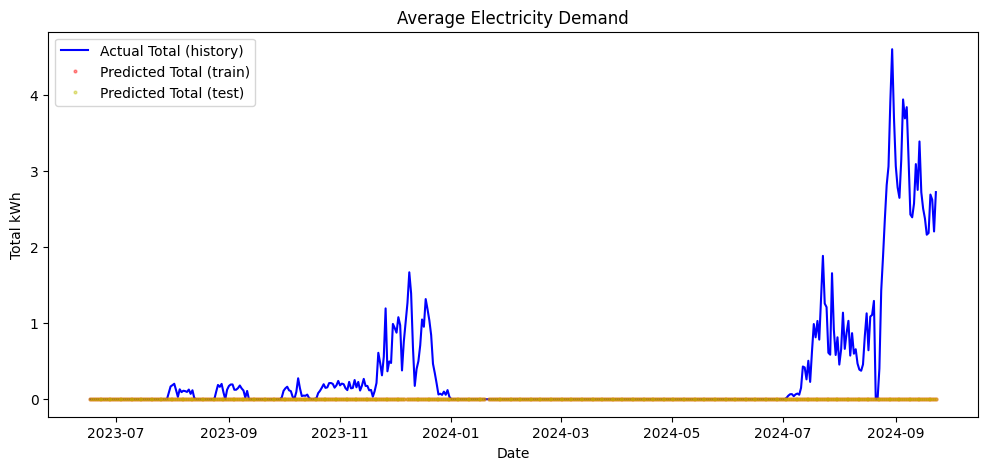

In [234]:
# --- Total demand (mean of all sources) ---
df_total = df[df['red']==1].groupby("Date")["kwh"].mean().reset_index()
pred_train_total = y_pred_train[y_pred_train['red']==1].groupby("Date")["kwh"].mean().reset_index()
pred_test_total = y_pred_test[y_pred_test['red']==1].groupby("Date")["kwh"].mean().reset_index()

fig = plt.figure(figsize=(12,5))
plt.plot(df_total["Date"], df_total["kwh"], 'b-', label="Actual Total (history)")
plt.plot(pred_train_total["Date"], pred_train_total["kwh"], 'ro', label="Predicted Total (train)", alpha=0.4, markersize=2)
plt.plot(pred_test_total["Date"], pred_test_total["kwh"], 'yo', label="Predicted Total (test)", alpha=0.4, markersize=2)
plt.title("Average Electricity Demand")
plt.xlabel("Date")
plt.ylabel("Total kWh")
plt.legend()
plt.show()
plt.close()

In [235]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    mlp = models.load_model(f'../models/{model_name}/model_{model_name}.h5', compile=False)

    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    extra_src = extra_src.merge(df_dummies, on='Source', how='left')
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, streamlined_prediction(mlp, X_ex)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [236]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name, second_extension='')
plot_model_validation(y_test, y_pred_test, model_name, second_extension='')

In [237]:
prepare_submission(preds_df, model_name)

                                             ID  pred_kwh
0     2024-09-24_consumer_device_12_data_user_1         0
1     2024-09-25_consumer_device_12_data_user_1         0
2     2024-09-26_consumer_device_12_data_user_1         0
3     2024-09-27_consumer_device_12_data_user_1         0
4     2024-09-28_consumer_device_12_data_user_1         0
...                                         ...       ...
6009   2024-10-20_consumer_device_8_data_user_9         0
6010   2024-10-21_consumer_device_8_data_user_9         0
6011   2024-10-22_consumer_device_8_data_user_9         0
6012   2024-10-23_consumer_device_8_data_user_9         0
6013   2024-10-24_consumer_device_8_data_user_9         0

[6014 rows x 2 columns]


---

### PK 11th Approach:  More climate features ------> Zindi score:  - Place:  !

- Based on PK 10th Approach

- minus one hot encoded devices

In [257]:
# --- Set up model version ---
model_name = model_id_and_folders('PK_11')

In [258]:
# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["wind_direction"] = np.arctan2(-df["U_Wind_Mean"], -df["V_Wind_Mean"]) * 180/np.pi
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    df["snow_cover_temp"] = df["SnowCover_Mean"] / 100 * df["Temp_Mean"]
    return df


def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df


# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date","red","blue","yellow"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

df = df.merge(df_dummies, on='Source', how='left')

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio", 'snow_cover_temp', 'wind_direction'
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")
     ] + ['red', 'blue', 'yellow']


X = df.set_index("Date")[feature_cols + ['Source']]
y = df.set_index("Date")[["Source", "kwh"
                          #, "red", "blue", "yellow"
                          ]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_src = X_train.pop('Source')
X_test_src = X_test.pop('Source')
y_train_src = y_train.pop('Source')
y_test_src = y_test.pop('Source')
# y_train_r = y_train.pop('red')
# y_test_r = y_test.pop('red')
# y_train_b = y_train.pop('blue')
# y_test_b = y_test.pop('blue')
# y_train_y = y_train.pop('yellow')
# y_test_y = y_test.pop('yellow')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-wrap
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,       # keep your datetime index
    columns=X_train.columns    # keep column names
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,       # keep your datetime index
    columns=X_test.columns    # keep column names
)


# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train_scaled.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

# --- Train ---
history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)
# save model
mlp.save(f'../models/{model_name}/model_{model_name}.h5')


# --- Predict on test and train ---
y_pred_train = mlp.predict(X_train_scaled).flatten()
y_pred_train = np.maximum(0, y_pred_train)
y_pred_test = mlp.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(0, y_pred_test)

# --- evaluate model on train and test splits ---
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MLP + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}")
print(f"MLP + Huber (test): RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}")

with open(f'../submissions/{model_name}/model_{model_name}_validation.txt', 'w') as file:
    file.write(f'MLP_{model_name} + Huber (train): RMSE={rmse_train:.3f}, MAPE={mape_train:.3f}'+
               f'\nMLP_{model_name} + Huber (test):  RMSE={rmse_test:.3f}, MAPE={mape_test:.3f}')
file.close()


# Re-wrap
y_pred_train = pd.DataFrame(
    y_pred_train,
    index=y_train.index,       # keep your datetime index
    columns=y_train.columns
)
y_pred_train['Source'] = y_train_src
# y_pred_train['red'] = y_train_r
# y_pred_train['blue'] = y_train_b
# y_pred_train['yellow'] = y_train_y
y_pred_test = pd.DataFrame(
    y_pred_test,
    index=y_test.index,       # keep your datetime index
    columns=y_test.columns
)
y_pred_test['Source'] = y_test_src
# y_pred_test['red'] = y_test_r
# y_pred_test['blue'] = y_test_b
# y_pred_test['yellow'] = y_test_y

Epoch 1/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - loss: 0.1471 - root_mean_squared_error: 1.4673 - val_loss: 0.1251 - val_root_mean_squared_error: 1.2632 - learning_rate: 0.0010
Epoch 2/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 0.1355 - root_mean_squared_error: 1.3676 - val_loss: 0.1347 - val_root_mean_squared_error: 1.3233 - learning_rate: 0.0010
Epoch 3/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - loss: 0.1325 - root_mean_squared_error: 1.3477 - val_loss: 0.1291 - val_root_mean_squared_error: 1.3215 - learning_rate: 0.0010
Epoch 4/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.1324 - root_mean_squared_error: 1.3564 - val_loss: 0.1250 - val_root_mean_squared_error: 1.2796 - learning_rate: 0.0010
Epoch 5/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 0.1305 - root_mean_squared_error: 1.3362 - val_loss: 0.1217 - val_root_mean_squared_error: 1.2514 - learning_rate: 0.0010
Epoch 6/100
851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.1287 - roo

6801/6801 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
MLP + Huber (train): RMSE=1.055, MAPE=41936757289862.812
MLP + Huber (test): RMSE=1.125, MAPE=41953019996554.602


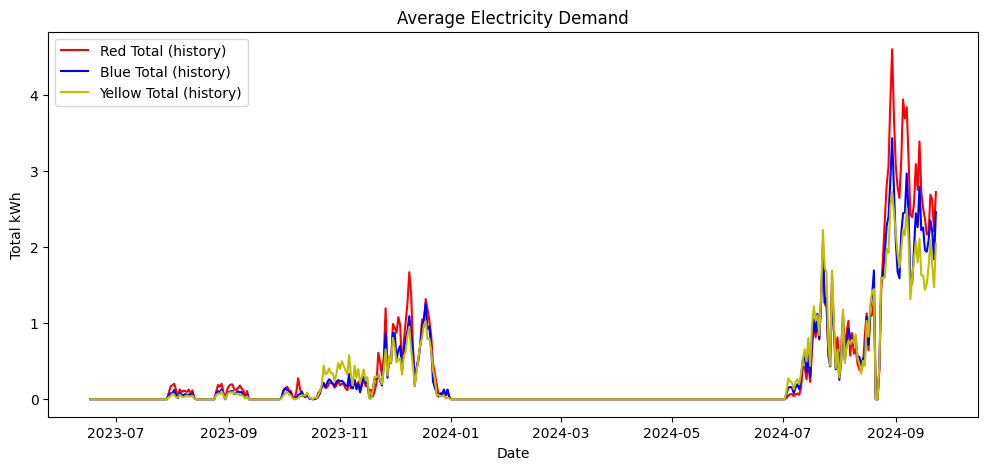

In [259]:
# --- Total demand (mean of all sources) ---
df_red = df[df['red']==1].groupby("Date")["kwh"].mean().reset_index()
df_blue = df[df['blue']==1].groupby("Date")["kwh"].mean().reset_index()
df_yellow = df[df['yellow']==1].groupby("Date")["kwh"].mean().reset_index()
# pred_train_total = y_pred_train[X_pred_train['red']==1].groupby("Date")["kwh"].mean().reset_index()
# pred_test_total = y_pred_test[y_pred_test['red']==1].groupby("Date")["kwh"].mean().reset_index()

fig = plt.figure(figsize=(12,5))
plt.plot(df_red["Date"], df_red["kwh"], 'r-', label="Red Total (history)")
plt.plot(df_blue["Date"], df_blue["kwh"], 'b-', label="Blue Total (history)")
plt.plot(df_yellow["Date"], df_yellow["kwh"], 'y-', label="Yellow Total (history)")
# plt.plot(pred_train_total["Date"], pred_train_total["kwh"], 'ro', label="Predicted Total (train)", alpha=0.4, markersize=2)
# plt.plot(pred_test_total["Date"], pred_test_total["kwh"], 'yo', label="Predicted Total (test)", alpha=0.4, markersize=2)
plt.title("Average Electricity Demand")
plt.xlabel("Date")
plt.ylabel("Total kWh")
plt.legend()
plt.show()
plt.close()

In [260]:
start_timer = time.perf_counter()  # high-precision timer

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    mlp = models.load_model(f'../models/{model_name}/model_{model_name}.h5', compile=False)

    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    extra_src = extra_src.merge(df_dummies[['Source', 'red', 'blue', 'yellow']], on='Source', how='left')
    lag_hist = hist.tail(30).reset_index(drop=True)
    
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, streamlined_prediction(mlp, X_ex)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)

# calculate prediction run time
end_timer = time.perf_counter()  # high-precision timer
runtime = end_timer - start_timer
with open(f'../submissions/{model_name}/model_{model_name}_prediction_time_{int(runtime//60)}m{int(runtime%60//1)}s.txt', 'w') as file:
    file.write(f'MLP_{model_name} prediction run time:')
    file.write(f'{int(runtime//60)} min {int(runtime%60//1)} sec')
file.close()

In [261]:
plot_example_sources(df, preds_df, y_pred_train, y_pred_test, model_name, second_extension='')
plot_model_validation(y_test, y_pred_test, model_name, second_extension='')

In [262]:
prepare_submission(preds_df, model_name)

                                             ID  \
0     2024-09-24_consumer_device_12_data_user_1   
1     2024-09-25_consumer_device_12_data_user_1   
2     2024-09-26_consumer_device_12_data_user_1   
3     2024-09-27_consumer_device_12_data_user_1   
4     2024-09-28_consumer_device_12_data_user_1   
...                                         ...   
6009   2024-10-20_consumer_device_8_data_user_9   
6010   2024-10-21_consumer_device_8_data_user_9   
6011   2024-10-22_consumer_device_8_data_user_9   
6012   2024-10-23_consumer_device_8_data_user_9   
6013   2024-10-24_consumer_device_8_data_user_9   

                                            pred_kwh  
0     tf.Tensor(0.37523532, shape=(), dtype=float32)  
1     tf.Tensor(0.36576504, shape=(), dtype=float32)  
2     tf.Tensor(0.45731997, shape=(), dtype=float32)  
3     tf.Tensor(0.36221272, shape=(), dtype=float32)  
4     tf.Tensor(0.36103463, shape=(), dtype=float32)  
...                                              ...  
60